# Pointing Model Utility 

This notebook is intended to help building initial pointing model for the Auxiliary Telescope. 

The user can define a grid of Az/El pointings that will be converted to RA/Dec target commands to the ATPtg. For each pointing the user can center the target and register the pointing throught ATPtg. The data can then be saved and used as input to TPOINT to compute pointing model parameters. 

Initially the process is very interactive. Once the process is well stablished we can turn this into a more automated process.

## Building Az/El pointing grid.

In [1]:
import numpy as np

import asyncio 

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, AltAz, ICRS, EarthLocation, Angle
from astroquery.vo_conesearch import ConeSearch
from astroquery.simbad import Simbad

import ipywidgets as widgets

import SALPY_ATPtg
import SALPY_ATMCS

from lsst.ts.salobj import Remote, State, set_summary_state

%matplotlib inline

The first step is to create Remotes to talk to the ATPtg and ATMCS componentes. The `include` is not required but it reduces the initialization time by only subscribing to the events, telemetry and commands that are actually used. 

In [2]:
atptg = Remote(SALPY_ATPtg, include=["summaryState",
                                     "start", 
                                     "enable", 
                                     "standby", 
                                     "raDecTarget", 
                                     "pointAddData"]
              )  # Remote to talk to the pointing component
atmcs = Remote(SALPY_ATMCS, include=["summaryState",
                                     "allAxesInPosition",
                                     "start", 
                                     "enable", 
                                     "standby"]
              )  # Remote to listen to the mount

Next, check the current summary state of both components. Note the use of `get` instead of `next` that is because we just need to check the last published value and don't need to wait for something. If no summary state was published, this will probably raise an exception. This can be due to multiple things, like the component not being up or even a network communication issue. 

In [3]:
print(f"ATPtg: {State(atptg.evt_summaryState.get().summaryState)!r}")
print(f"ATMCS: {State(atmcs.evt_summaryState.get().summaryState)!r}")

AttributeError: 'NoneType' object has no attribute 'summaryState'

We now use the `set_summary_state` utility function provided by `salobj` to enable both components. This will work (or should work) no matter what the current state of the CSC is, as long as the communication is working.

In [4]:
await set_summary_state(atptg, State.ENABLED)

In [5]:
await set_summary_state(atmcs, State.ENABLED)

In [6]:
print(f"ATPtg: {State(atptg.evt_summaryState.get().summaryState)!r}")
print(f"ATMCS: {State(atmcs.evt_summaryState.get().summaryState)!r}")

ATPtg: <State.ENABLED: 2>
ATMCS: <State.ENABLED: 2>


Next step is setting up the parameters for the run. Currently we use a simple `NxN` pointing scheme in both azimuth and altitude. This will likely need to be improved as regions with lower elevation may need a better cover. 

TODO: Check with pointing component vendors a better grid. 

In [7]:
n_az = 5  # Maximum number of pointings in azimuth
n_alt = 5  # Number of pointings in altitude
mag_limit = 7  # Magnitude limit

In [8]:
alt_min = Angle(35.*u.deg)
alt_max = Angle(70.*u.deg)
d_alt = (alt_max-alt_min) / n_alt

In [9]:
az_min = Angle(0.*u.deg)
az_max = Angle(360.*u.deg)

In [10]:
alt_grid = np.linspace(alt_min, alt_max, n_alt)

Building the Azimuth grid. 

For each altitude it will select a quasi-uniform number of values in azimuth.

In [11]:
az_grid = np.zeros((n_alt, n_az))

for i in range(n_alt):
#     n_az_add = int(np.floor(np.cos(alt_grid[i].radian)*max_n_az))
#     d_az = (az_max-az_min) / n_az
    d_az = (az_max-az_min) / n_az
    zero = (np.random.rand()+0.5)*d_az.deg
    zero = i*d_az.deg/4
#     az_grid.append(np.arange(az_min.deg+zero, az_max.deg+zero, d_az.deg))
    az_grid[i] += np.arange(az_min.deg+zero, az_max.deg+zero, d_az.deg)

At this point altitude is stored in a 1-d array and azimuth is stored in a matrix. I'll flatten these arrays so they are both 1-d with a one to one mapping.

I'm also preparing the order of the pointings here so we will go over from lower to higher altitutes instead of doing a constant altitude sweap. 

In [12]:
az_pt_grid = np.zeros(n_alt*n_az)
el_pt_grid = np.zeros(n_alt*n_az)

for i in range(n_az):
    for j in range(n_alt):
        az_pt_grid[i*n_az + j] = az_grid[j][i]
        el_pt_grid[i*n_az + j] = alt_grid[j].deg

Make a polar plot of the pointings

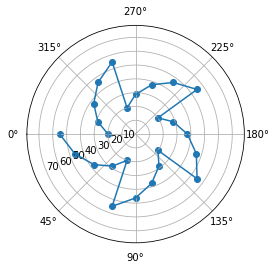

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location('W', offset=0)

c = ax.scatter(np.radians(az_pt_grid), 90.-el_pt_grid)
l = ax.plot(np.radians(az_pt_grid), 90.-el_pt_grid)

# for i in range(n_alt):
#     az = np.radians(az_grid[i])
#     el = np.zeros(len(az))+alt_grid[i].deg
#     c = ax.scatter(az, 90.-el)


Now for each Az/El pointing try to find a bright star to point.

In [14]:
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                                    lat=-30.244728*u.deg,
                                                    height=2663.0*u.m)

In [15]:
customSimbad = Simbad()
customSimbad.add_votable_fields('distance_result', "fluxdata(V)")
customSimbad.TIMEOUT = 10

In [16]:
async def point(az, el):
    """A method to point.
    """
    
    current_time = Time.now()

    elaz = AltAz(alt=el, az=az, 
                 obstime=current_time.tai, 
                 location=location)

    radec = elaz.transform_to(ICRS)

    _ra = radec.ra.to_string(u.deg, decimal=True)
    _dec = radec.dec.to_string(u.deg, decimal=True, alwayssign=True)
    r = Angle(4.*u.deg).to_string(u.deg, decimal=True)

    criteria = f"region(circle,ICRS,{_ra} {_dec},{r}d) & Vmag < {mag_limit}"
    try:
        result_table = customSimbad.query_criteria(criteria)
    except Exception as e:
        print(f"Error getting target from Simbad. Skipping target {elaz!r}.")
        return -1

    if len(result_table) == 0:
        print(f"Could not find a suitable target around {elaz}.")
        return -1

    # sort by magnitude so first is the brightest 
    result_table.sort('FLUX_V')

    target_radec = SkyCoord(Angle(result_table['RA'][0], unit=u.hour), 
                    Angle(result_table['DEC'][0], unit=u.deg), frame=ICRS)

    t_id = str(result_table['MAIN_ID'][0])
    t_ra = result_table['RA'][0]
    t_dec = result_table['DEC'][0]
    t_mag = result_table['FLUX_V'][0]
    print(f"Pointing to {t_id:15}: {t_ra} {t_dec} (VMag:{t_mag:5.2f})")

    atptg.cmd_raDecTarget.set(
        targetName=f"{result_table['MAIN_ID'][0]}",
        targetInstance=SALPY_ATPtg.ATPtg_shared_TargetInstances_current,
        frame=SALPY_ATPtg.ATPtg_shared_CoordFrame_icrs,
        epoch=2000,  # should be ignored: no parallax or proper motion
        equinox=2000,  # should be ignored for ICRS
        ra=target_radec.ra.hour,
        declination=target_radec.dec.deg,
        parallax=0,
        pmRA=0,
        pmDec=0,
        rv=0,
        dRA=0,
        dDec=0,
        rotPA=0,
        rotFrame=SALPY_ATPtg.ATPtg_shared_RotFrame_target,
        rotMode=SALPY_ATPtg.ATPtg_shared_RotMode_field,
    )
    atmcs.evt_allAxesInPosition.flush()
    try:
        await atptg.cmd_raDecTarget.start()
    except Exception as e:
        print("Could not point to target.")
        return -1
        
    in_position = await atmcs.evt_allAxesInPosition.next(flush=False)
    while not in_position.inPosition:
        in_position = await atmcs.evt_allAxesInPosition.next(flush=False)
    print(f"Mount in position.")
    return 0
#     await asyncio.sleep(wait_time)
#     print("Done... Stop tracking...")
#     await atptg.cmd_stopTracking.start()
#     print("Next...")




In [17]:
async def wait_center():
    while True:
        opt = input("Center telescope and choose action (press ?<enter>, for list of actions): ")
        
        if opt == 'x':
            print("Telescope centered. Adding data and continuing...")
            await atptg.cmd_pointAddData.start()
            return 0
        elif opt == 's':
            print("Skipping...")
            return 1
        elif opt == 't':
            print("Stopping test...")
            return -1
        elif opt == '?':
            print("""Options are:
            x - Telescope centered, add data and continue.
            s - Skipp point and continue.
            t - Terminate test.
            """)
    

Store pass/fail pointings. 

In [18]:
pt_grid_done = np.zeros(n_alt*n_az, dtype=np.bool)

In [19]:
for i in range(len(az_pt_grid)):
    
    if not pt_grid_done[i]:
        print(f"Pointing to: az={Angle(az_pt_grid[i]*u.deg)} / el {Angle(el_pt_grid[i]*u.deg)}")
        ret_val = await point(az=Angle(az_pt_grid[i]*u.deg),
                              el=Angle(el_pt_grid[i]*u.deg))
    else:
        print(f"Pointing {i} already completed. Skipping...")
        continue
        
    if ret_val == 0.:
        wait_ret_val = await wait_center()
        await atptg.cmd_stopTracking.start()
        if wait_ret_val < 0:
            break
        pt_grid_done[i] = wait_ret_val == 0
    else:
        print(f"Failed to point to position {i} in the grid. continuing...")
            

print("Done...")

Pointing to: az=0.0 deg / el 35.0 deg
Pointing to b'* iot Tau'   : 05 03 05.7455 +21 35 23.865 (VMag: 4.61)
Mount in position.
Center telescope and choose action (press ?<enter>, for list of actions): x
Telescope centered. Adding data and continuing...
Pointing to: az=18.0 deg / el 43.75 deg
Pointing to b'* nu. Ori'   : 06 07 34.3258 +14 46 06.506 (VMag: 4.40)
Mount in position.
Center telescope and choose action (press ?<enter>, for list of actions): x
Telescope centered. Adding data and continuing...
Pointing to: az=36.0 deg / el 52.5 deg
Pointing to b'*  18 Mon'   : 06 47 51.6475 +02 24 43.840 (VMag: 4.47)
Mount in position.
Center telescope and choose action (press ?<enter>, for list of actions): x
Telescope centered. Adding data and continuing...
Pointing to: az=54.0 deg / el 61.25 deg
Error getting target from Simbad. Skipping target <AltAz Coordinate (obstime=2019-05-20 18:03:36.169794, location=(1819093.5687622512, -5208411.682796104, -3195180.61110659) m, pressure=0.0 hPa, tem

In [20]:
pt_grid_done

array([ True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False])

In [21]:
for i in range(len(az_pt_grid)):
    
    if not pt_grid_done[i]:
        print(f"Pointing to: az={Angle(az_pt_grid[i]*u.deg)} / el {Angle(el_pt_grid[i]*u.deg)}")
        ret_val = await point(az=Angle(az_pt_grid[i]*u.deg),
                              el=Angle(el_pt_grid[i]*u.deg))
    else:
        print(f"Pointing {i} already completed. Skipping...")
        continue
        
    if ret_val == 0.:
        wait_ret_val = await wait_center()
        await atptg.cmd_stopTracking.start()
        if wait_ret_val < 0:
            break
        pt_grid_done[i] = wait_ret_val == 0
    else:
        print(f"Failed to point to position {i} in the grid. continuing...")
            

print("Done...")

Pointing 0 already completed. Skipping...
Pointing 1 already completed. Skipping...
Pointing 2 already completed. Skipping...
Pointing to: az=54.0 deg / el 61.25 deg
Pointing to b'* tet CMa'   : 06 54 11.3997 -12 02 19.061 (VMag: 4.08)
Mount in position.
Center telescope and choose action (press ?<enter>, for list of actions): x
Telescope centered. Adding data and continuing...
Pointing 4 already completed. Skipping...
Pointing 5 already completed. Skipping...
Pointing 6 already completed. Skipping...
Pointing to: az=108.0 deg / el 52.5 deg
Pointing to b'* q Pup'     : 08 18 33.3129 -36 39 33.439 (VMag: 4.40)
Mount in position.
Center telescope and choose action (press ?<enter>, for list of actions): x
Telescope centered. Adding data and continuing...
Pointing 8 already completed. Skipping...
Pointing 9 already completed. Skipping...
Pointing 10 already completed. Skipping...
Pointing to: az=162.0 deg / el 43.75 deg
Pointing to b'* zet Vol'   : 07 41 49.2610 -72 36 21.956 (VMag: 3.94)


In [22]:
pt_grid_done

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [23]:
for i in range(len(az_pt_grid)):
    
    if not pt_grid_done[i]:
        print(f"Pointing to: az={Angle(az_pt_grid[i]*u.deg)} / el {Angle(el_pt_grid[i]*u.deg)}")
        ret_val = await point(az=Angle(az_pt_grid[i]*u.deg),
                              el=Angle(el_pt_grid[i]*u.deg))
    else:
        print(f"Pointing {i} already completed. Skipping...")
        continue
        
    if ret_val == 0.:
        wait_ret_val = await wait_center()
        await atptg.cmd_stopTracking.start()
        if wait_ret_val < 0:
            break
        pt_grid_done[i] = wait_ret_val == 0
    else:
        print(f"Failed to point to position {i} in the grid. continuing...")
            

print("Done...")

Pointing 0 already completed. Skipping...
Pointing 1 already completed. Skipping...
Pointing 2 already completed. Skipping...
Pointing 3 already completed. Skipping...
Pointing 4 already completed. Skipping...
Pointing 5 already completed. Skipping...
Pointing 6 already completed. Skipping...
Pointing 7 already completed. Skipping...
Pointing 8 already completed. Skipping...
Pointing 9 already completed. Skipping...
Pointing 10 already completed. Skipping...
Pointing 11 already completed. Skipping...
Pointing to: az=180.0 deg / el 52.5 deg
Error getting target from Simbad. Skipping target <AltAz Coordinate (obstime=2019-05-20 18:14:50.185035, location=(1819093.5687622512, -5208411.682796104, -3195180.61110659) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron): (az, alt) in deg
    (180., 52.5)>.
Failed to point to position 12 in the grid. continuing...
Pointing 13 already completed. Skipping...
Pointing 14 already completed. Skipping...
Pointing 15 alre

In [ ]:
await set_summary_state(atptg, State.STANDBY)

In [ ]:
await set_summary_state(atmcs, State.STANDBY)

In [ ]:
print(f"ATPtg: {State(atptg.evt_summaryState.get().summaryState)!r}")
print(f"ATMCS: {State(atmcs.evt_summaryState.get().summaryState)!r}")

# IGNORE FROM HERE ON

In [ ]:
current_time = Time.now()

elaz = AltAz(alt=alt_grid[i], az=Angle(az_grid[i][0]*u.deg), 
             obstime=current_time.tai, 
             location=location)

radec = elaz.transform_to(ICRS)

In [ ]:
print(elaz)
print(radec)

In [ ]:
customSimbad = Simbad()

In [ ]:
customSimbad.add_votable_fields('distance_result', "fluxdata(V)")

In [ ]:
_ra = radec.ra.to_string(u.deg, decimal=True)
_dec = radec.dec.to_string(u.deg, decimal=True)
r = Angle(4.*u.deg).to_string(u.deg, decimal=True)

criteria = f"region(circle,ICRS,{_ra} {_dec},{r}d) & Vmag < 7"
print(criteria)
result_table = customSimbad.query_criteria(criteria)
print(result_table)

In [ ]:
result_table.sort('FLUX_V')

In [ ]:
Angle(result_table['RA'][0], unit=u.hour), Angle(result_table['DEC'][0], unit=u.deg)

In [ ]:
target_radec = SkyCoord(Angle(result_table['RA'][0], unit=u.hour), 
                        Angle(result_table['DEC'][0], unit=u.deg), frame=ICRS)

In [ ]:
target_radec

In [ ]:
plt.hist(result_table['FLUX_V'])

In [ ]:
r = 1. * u.deg
result_table = Simbad.query_region(radec, radius=r)
# c = coordinates.SkyCoord("05h35m17.3s -05d23m28s", frame='icrs')

In [ ]:
print(result_table.columns)

In [ ]:
print(result_table)

In [ ]:
print(az, el)

In [ ]:
Simbad.list_votable_fields()

In [ ]:
Simbad.get_field_description("fluxdata(filtername)")

In [ ]:
Simbad.get_field_description("V")

In [ ]:
Simbad.get_votable_fields()

In [ ]:
Simbad.ROW_LIMIT 

In [ ]:
Simbad.query_criteria?

In [ ]:
radec.ra.to_string(u.hour, decimal=False, sep=":")
radec.dec.to_string(u.deg, decimal=False, sep=":")

In [ ]:
Angle(r).to_string(u.deg)